# pCrunch's Aeroelastic Output class

The `AeroelasticOutput` class is a general container for time-series based data for a single environmental condition (i.e., a single incoming wind spead and turbulence seed value).  This might be a single run of your aeroelastic multibody simulation tool (OpenFAST or HAWC2 or Bladed or QBlade or in-house equivalents) in a larger parametric variation for design load case (DLC) analysis.  The `AeroelasticOutput` class provides data containers and common or convenient manipulations of the data for engineering analysis.  

Analysis that involve multiple time-series simulations, such as a full run of multiple wind speeds and seeds, which yield multiple AeroelasticOutput instances, is done in the *Crunch class*.

This file lays out some workflows and showcases capabilities of the `AeroelasticOutput` class.

## Creating a new class instance

The `AeroelasticOutput` class can be initialized from an output file or from existing data structures.  pCrunch provides a reader for OpenFAST output files (both binary and ascii).  To expand pCrunch for use with other aeroelastic multibody codes, users could simply use the `openfast_readers.py` file as a template.  If you already have the data in Python, then data structures such as dictionaries, lists, NumPy arrays, and Pandas DataFrames can all be used as a constructor.  Here are some examples with each `myobj` representing a valid AeroelatsicOutput instance:

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pCrunch import AeroelasticOutput, read, FatigueParams

thisdir = os.path.realpath('')
datadir = os.path.join(thisdir, '..', 'pCrunch', 'test', 'data')

# OpenFAST output files
myobj_of_ascii = read( os.path.join(datadir, 'DLC2.3_1.out') )
myobj_of_bin   = read( os.path.join(datadir, 'Test2.outb') )

# Existing data structures
mydata = {
    "Time": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "WindVxi": [7, 7, 7, 7, 7, 8, 8, 8, 8, 8],
    "WindVyi": [0] * 10,
    "WindVzi": [0] * 10,
}

# From a dictionary
myobj_from_dict  = AeroelasticOutput(mydata)

# From a Pandas DataFrame
myobj_from_df    = AeroelasticOutput( pd.DataFrame(mydata) )

# From Python lists
chan_labels      = list( mydata.keys() )
ts_data          = [m for m in mydata.values()]
myobj_from_list  = AeroelasticOutput(ts_data, chan_labels)

# From a Numpy array
myobj_from_numpy = AeroelasticOutput(np.array(ts_data), chan_labels)

# As a copy from an existing output (especially helpful when needing to filter the core data)
myobj_copy       = myobj_from_numpy.copy()

Additional, optional arguments can also be passed that specify a label, a description, and a vector of units for the data channels:

In [63]:
myunits = ['s', 'm/s', 'm/s', 'm/s']
myobj_from_dict = AeroelasticOutput(mydata, name='pseudodata', description='pCrunch example', units=myunits)

Magnitude channels, extremes, and fatigue are presented in greater detail below.  These additional inputs can also be specified in the constructor:

In [64]:
# Vector magnitudes
mc = {"Wind": ["WindVxi", "WindVyi", "WindVzi"]}

# Channel-specific fatigue properties
fc = {
    "RootMc1": FatigueParams(lifetime=25.0, slope=10.0, ultimate_stress=6e8, load2stress=250.0, S_intercept=5e9),
    "RootMc2": FatigueParams(lifetime=25.0, slope=10.0, ultimate_stress=6e8, load2stress=250.0, S_intercept=5e9),
    "RootMc3": FatigueParams(lifetime=25.0, slope=10.0, ultimate_stress=6e8, load2stress=250.0, S_intercept=5e9),
}

# Channels to focus on for extreme event tabulation
ec = ["RotSpeed", "RotThrust", "RotTorq"]

# Can also add some batch data operations in the constructor (many more available in Batch Processing below)
myobj_mc = AeroelasticOutput(mydata, magnitude_channels=mc, trim_data=[2, 8], fatigue_channels=fc, extreme_channels=ec)


## Data structures and access

pCrunch stores the time series data as a Numpy array and the channel names as a list.  More sophisticated data containers, such as netcdf or hdf5, could be adopted in future work, but the simplicity, familiarity, and accessibility of the data containers should help users adopt pCrunch into their workflows.  Easy converstions back to a Python dictionary or Pandas dataframe are available:

In [65]:
myobj_from_dict.channels

['Time', 'WindVxi', 'WindVyi', 'WindVzi']

In [66]:
myobj_from_dict.data

array([[ 1,  7,  0,  0],
       [ 2,  7,  0,  0],
       [ 3,  7,  0,  0],
       [ 4,  7,  0,  0],
       [ 5,  7,  0,  0],
       [ 6,  8,  0,  0],
       [ 7,  8,  0,  0],
       [ 8,  8,  0,  0],
       [ 9,  8,  0,  0],
       [10,  8,  0,  0]])

In [67]:
myobj_from_dict.to_dict()

{'Time': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'WindVxi': [7, 7, 7, 7, 7, 8, 8, 8, 8, 8],
 'WindVyi': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'WindVzi': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [68]:
myobj_from_dict.to_df()

,Time,WindVxi,WindVyi,WindVzi
0,1,7,0,0
1,2,7,0,0
2,3,7,0,0
3,4,7,0,0
4,5,7,0,0
5,6,8,0,0
6,7,8,0,0
7,8,8,0,0
8,9,8,0,0
9,10,8,0,0


Accessing the data for a particular channel is done using familiar dictionary or DataFrame syntax.  A `.time` property is also available as that is assumed to be common to all datasets

In [69]:
myobj_from_dict['Time']

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [70]:
myobj_from_dict.time

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [71]:
myobj_from_dict['WindVxi']

array([7, 7, 7, 7, 7, 8, 8, 8, 8, 8])

If working with the data or summary statistics outside of the AeroelasticOutput object, it can be help to have an easy way to grab the index into the channel vector.  This is available via:

In [72]:
myobj_from_dict.chan_idx('WindVxi')

1

## Adding new channels, dropping channels, and math operations on channel data

Significant new capability has been added in pCrunch v2 to enable easy addition of new data channels, especially from mathematically manipulating existing channels.  There are also easy short cuts to add channels that are vector magnitudes and load rose sectors based on vector components, which is helpful for tower and blade loading analysis.

As with the constructor, new channel data can be added with a dictionary, list, Pandas Series, or Numpy array:

In [73]:
# Inputting a dictionary new channel
myobj_from_dict.add_channel( {'New1': np.sin(myobj_from_dict['Time'])} )

# As a DataFrame
myobj_from_dict.add_channel( pd.DataFrame({'New2': np.cos(myobj_from_dict['Time'])}) )

# As a Numpy array or list and channel as a string
myobj_from_dict.add_channel( np.tan(myobj_from_dict['Time']), 'New3' )

myobj_from_dict.to_df()

,Time,WindVxi,WindVyi,WindVzi,New1,New2,New3
0,1.0,7.0,0.0,0.0,0.841471,0.540302,1.557408
1,2.0,7.0,0.0,0.0,0.909297,-0.416147,-2.185040
2,3.0,7.0,0.0,0.0,0.141120,-0.989992,-0.142547
3,4.0,7.0,0.0,0.0,-0.756802,-0.653644,1.157821
4,5.0,7.0,0.0,0.0,-0.958924,0.283662,-3.380515
5,6.0,8.0,0.0,0.0,-0.279415,0.960170,-0.291006
6,7.0,8.0,0.0,0.0,0.656987,0.753902,0.871448
7,8.0,8.0,0.0,0.0,0.989358,-0.145500,-6.799711
8,9.0,8.0,0.0,0.0,0.412118,-0.911130,-0.452316
9,10.0,8.0,0.0,0.0,-0.544021,-0.839072,0.648361


A new feature in pCrunch that restores some of the old capability in mcrunch is the ability to write string expressions to add a new channel.  String names should match channel names and all standard python math expressions are allowed.  Users can also use `calculate_channel` in addition to `add_channel` for mcrunch consistency.

In [74]:
myobj_from_dict.add_channel( 'WindVxi**2 + WindVyi + New1/New2', 'New4' )
myobj_from_dict.to_df()

,Time,WindVxi,WindVyi,WindVzi,New1,New2,New3,New4
0,1.0,7.0,0.0,0.0,0.841471,0.540302,1.557408,50.557408
1,2.0,7.0,0.0,0.0,0.909297,-0.416147,-2.185040,46.814960
2,3.0,7.0,0.0,0.0,0.141120,-0.989992,-0.142547,48.857453
3,4.0,7.0,0.0,0.0,-0.756802,-0.653644,1.157821,50.157821
4,5.0,7.0,0.0,0.0,-0.958924,0.283662,-3.380515,45.619485
5,6.0,8.0,0.0,0.0,-0.279415,0.960170,-0.291006,63.708994
6,7.0,8.0,0.0,0.0,0.656987,0.753902,0.871448,64.871448
7,8.0,8.0,0.0,0.0,0.989358,-0.145500,-6.799711,57.200289
8,9.0,8.0,0.0,0.0,0.412118,-0.911130,-0.452316,63.547684
9,10.0,8.0,0.0,0.0,-0.544021,-0.839072,0.648361,64.648361


Channels can also be dropped using string wildcards (`drop_channel`, `remove_channel`, and `delete_channel` are all valid)

In [75]:
myobj_from_dict.drop_channel('New*')
myobj_from_dict.to_df()

,Time,WindVxi,WindVyi,WindVzi
0,1.0,7.0,0.0,0.0
1,2.0,7.0,0.0,0.0
2,3.0,7.0,0.0,0.0
3,4.0,7.0,0.0,0.0
4,5.0,7.0,0.0,0.0
5,6.0,8.0,0.0,0.0
6,7.0,8.0,0.0,0.0
7,8.0,8.0,0.0,0.0
8,9.0,8.0,0.0,0.0
9,10.0,8.0,0.0,0.0


### Derivatives with respect to time

As a common operation, new channels can be added that are gradients of existing channels.  This uses the Numpy `gradient` method with double precision central differencing in the middle of the timeseries and one-sided differencing at the edges.

In [76]:
myobj_from_dict.add_gradient_channel('WindVxi','du_dt')
myobj_from_dict.to_df()

,Time,WindVxi,WindVyi,WindVzi,du_dt
0,1.0,7.0,0.0,0.0,0.0
1,2.0,7.0,0.0,0.0,0.0
2,3.0,7.0,0.0,0.0,0.0
3,4.0,7.0,0.0,0.0,0.0
4,5.0,7.0,0.0,0.0,0.5
5,6.0,8.0,0.0,0.0,0.5
6,7.0,8.0,0.0,0.0,0.0
7,8.0,8.0,0.0,0.0,0.0
8,9.0,8.0,0.0,0.0,0.0
9,10.0,8.0,0.0,0.0,0.0


### Vector magnitudes

Computing vector magnitudes is a common operation, which can be done by hand using one of the approaches above, or in the constructor by passing in a dictionary:

In [77]:
mc = {"Wind": ["WindVxi", "WindVyi", "WindVzi"]}
myobj_with_mag = AeroelasticOutput(mydata, magnitude_channels=mc)
myobj_with_mag.to_df()

,Time,WindVxi,WindVyi,WindVzi,Wind
0,1.0,7.0,0.0,0.0,7.0
1,2.0,7.0,0.0,0.0,7.0
2,3.0,7.0,0.0,0.0,7.0
3,4.0,7.0,0.0,0.0,7.0
4,5.0,7.0,0.0,0.0,7.0
5,6.0,8.0,0.0,0.0,8.0
6,7.0,8.0,0.0,0.0,8.0
7,8.0,8.0,0.0,0.0,8.0
8,9.0,8.0,0.0,0.0,8.0
9,10.0,8.0,0.0,0.0,8.0


The magnitude channels can also be added after the fact too:

In [78]:
myobj_with_mag = AeroelasticOutput(mydata)
myobj_with_mag.add_magnitude_channels(mc)
myobj_with_mag.to_df()

,Time,WindVxi,WindVyi,WindVzi,Wind
0,1.0,7.0,0.0,0.0,7.0
1,2.0,7.0,0.0,0.0,7.0
2,3.0,7.0,0.0,0.0,7.0
3,4.0,7.0,0.0,0.0,7.0
4,5.0,7.0,0.0,0.0,7.0
5,6.0,8.0,0.0,0.0,8.0
6,7.0,8.0,0.0,0.0,8.0
7,8.0,8.0,0.0,0.0,8.0
8,9.0,8.0,0.0,0.0,8.0
9,10.0,8.0,0.0,0.0,8.0


### Load Roses

Neither vector components nor magnitude correctly capture the load impacts on a tower base or blade root.  A more appropriate approach is a load rose, where the 360-degree annulus is divided into sectors and the vector components are combined with sin() and cos() to compute the load impacts on each sector.  pCrunch automates this process and it results in the creation of n_sector new channels of data.  An example:

In [79]:
lr = {'TwrBs': ['TwrBsFxt', 'TwrBsFyt']}
myobj_of_bin.add_load_rose(lr, nsec=6)

Added channel, TwrBs0
Added channel, TwrBs60
Added channel, TwrBs120
Added channel, TwrBs180
Added channel, TwrBs240
Added channel, TwrBs300


### Binning, windowing, averaging

Another common operation is to downsample the time series signals in various ways.  Options include:

- Trim the data to remove transients or otherwise narrow the series
- Windowed smoothing via correlation
- Binned averages

In [80]:
# Trimming data can be done to the full data set
print( myobj_of_bin.elapsed_time, myobj_of_bin.num_timesteps )
myobj_of_bin.trim_data(100, 600)
print( myobj_of_bin.elapsed_time, myobj_of_bin.num_timesteps )

600.0000089406967 6001
499.9000074490905 5000


In [81]:
# Time windowing convolves an averaging window with the time signal and sets this as the new data array with the same timestep, 
# but a shorter signal that covers the valid windowing region.
myobj_of_bin.time_averaging(30.0)
print( myobj_of_bin.elapsed_time, myobj_of_bin.num_timesteps, myobj_of_bin.dt)

470.1000070050359 4702 0.10000000149011612


In [82]:
# Time binning results in a downsampled data set that represents the average for each bin
myobj_of_bin.time_binning(30.0)
print( myobj_of_bin.elapsed_time, myobj_of_bin.num_timesteps, myobj_of_bin.dt)

445.10000663250685 16 30.000000447034836


## Frequency domain spectra

Power spectral density in the frequency domain is made readily available using the SciPy `welch` function.  A new AeroelasticOutput object is returned with frequency taking the place of time and PSD content in the frequency domain taking the place of the time-domain data.

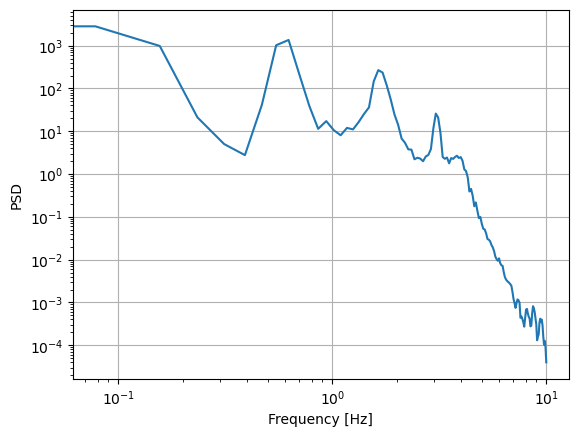

In [83]:
freq_obj = myobj_of_ascii.psd()
plt.loglog(freq_obj['Freq'], freq_obj['TwrBsFyt'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.grid()

## Statistics, extremes, and many other quantities

In [84]:
# Many other statistics of the data are readily available. A quick summary for each channel of data is available in a dictionary
myobj_from_df.summary_stats()

{'Time': {'min': 1,
  'max': 10,
  'std': 2.8722813232690143,
  'mean': 5.5,
  'median': 5.5,
  'abs': 10,
  'integrated': 49.5},
 'WindVxi': {'min': 7,
  'max': 8,
  'std': 0.5,
  'mean': 7.5,
  'median': 7.5,
  'abs': 8,
  'integrated': 67.5},
 'WindVyi': {'min': 0,
  'max': 0,
  'std': 0.0,
  'mean': 0.0,
  'median': 0.0,
  'abs': 0,
  'integrated': 0.0},
 'WindVzi': {'min': 0,
  'max': 0,
  'std': 0.0,
  'mean': 0.0,
  'median': 0.0,
  'abs': 0,
  'integrated': 0.0}}

In [85]:
myobj_from_df.summary_stats()['WindVxi']['mean']

7.5

In [86]:
# It is helpful to know the value of other channels when one of interest is at its extreme value
myobj_from_df.extremes()

{'Time': {'Time': 10, 'WindVxi': 8, 'WindVyi': 0, 'WindVzi': 0},
 'WindVxi': {'Time': 6, 'WindVxi': 8, 'WindVyi': 0, 'WindVzi': 0},
 'WindVyi': {'Time': 1, 'WindVxi': 7, 'WindVyi': 0, 'WindVzi': 0},
 'WindVzi': {'Time': 1, 'WindVxi': 7, 'WindVyi': 0, 'WindVzi': 0}}

In [87]:
# This can be done for the whole dataset (which can be a large NxN output), or specific channels
myobj_of_ascii.extremes(['RotTorq','TwrBsFyt'])

{'RotTorq': {'Time': 54.45, 'RotTorq': 2650.0, 'TwrBsFyt': -22.0},
 'TwrBsFyt': {'Time': 70.85, 'RotTorq': -212.0, 'TwrBsFyt': 53.6}}

A larger laundry list of statistics are available as data properties (meaning they don't have to be called as a function):

In [88]:
# Indices to the minimum value for each channel
myobj_from_df.idxmins

array([0, 0, 0, 0])

In [89]:
# Indices to the maximum value for each channel
myobj_from_df.idxmaxs

array([9, 5, 0, 0])

In [90]:
# Minimum value of each channel
myobj_from_df.minima

array([1, 7, 0, 0])

In [91]:
# Maximum value of each channel
myobj_from_df.maxima

array([10,  8,  0,  0])

In [92]:
# Maximum value of absolute values of each channel
myobj_from_df.absmaxima

array([10,  8,  0,  0])

In [93]:
# The range of data values (max - min)
myobj_from_df.ranges

array([9, 1, 0, 0])

In [94]:
# Channel indices which vary in time
myobj_from_df.variable

array([0, 1])

In [95]:
# Channel indices which are constant in time
myobj_from_df.constant

array([2, 3])

In [96]:
# Sum of channel values over time
myobj_from_df.sums

array([55, 75,  0,  0])

In [97]:
# Sum of channel values over time to the second power
myobj_from_df.sums_squared

array([385, 565,   0,   0])

In [98]:
# Sum of channel values over time to the third power
myobj_from_df.sums_cubed

array([3025, 4275,    0,    0])

In [99]:
# Sum of channel values over time to the fourth power
myobj_from_df.sums_fourth

array([25333, 32485,     0,     0])

In [100]:
# Second moment of the timeseries for each channel
myobj_from_df.second_moments

array([8.25, 0.25, 0.  , 0.  ])

In [101]:
# Third moment of the timeseries for each channel
myobj_from_df.third_moments

array([0., 0., 0., 0.])

In [102]:
# Fourth moment of the timeseries for each channel
myobj_from_df.fourth_moments

array([1.208625e+02, 6.250000e-02, 0.000000e+00, 0.000000e+00])

In [103]:
# Mean of channel values over time
myobj_from_df.means

array([5.5, 7.5, 0. , 0. ])

In [104]:
# Median of channel values over time
myobj_from_df.medians

array([5.5, 7.5, 0. , 0. ])

In [105]:
# Standard deviation of channel values over time
myobj_from_df.stddevs

array([2.87228132, 0.5       , 0.        , 0.        ])

In [106]:
# Skew of channel values over time
myobj_from_df.skews

/Users/gbarter/devel/pCrunch/pCrunch/aeroelastic_output.py:416: RuntimeWarning: invalid value encountered in divide
  return self.third_moments / np.sqrt(self.second_moments) ** 3


array([ 0.,  0., nan, nan])

In [107]:
# Kurtosis of channel values over time
myobj_from_df.kurtosis

/Users/gbarter/devel/pCrunch/pCrunch/aeroelastic_output.py:420: RuntimeWarning: invalid value encountered in divide
  return self.fourth_moments / self.second_moments ** 2


array([1.77575758, 1.        ,        nan,        nan])

In [108]:
# Integration of channel values over time
myobj_from_df.integrated

array([49.5, 67.5,  0. ,  0. ])

In [109]:
# Special instance of the integration that specifically uses
# the Power channel string to integrate over time and calculate energy
myobj_of_ascii.compute_energy('GenPwr') 

72637.25

In [110]:
# Total "travel" during a simulation, which is helpful for pitch and yaw systems
myobj_of_ascii.total_travel('BldPitch1') 

89.99999999999991

## Calculating fatigue

pCrunch can compute damage equivalent loads and, optionally, traditional Palmgren-Miner damage.  Computing these quantities requires additional inputs for material properties, S-N curve parameters, and some algorithm choices (although most of the work is handed off to the `fatpack` module.  These additional parameters would most likely vary from one channel to the next.  For instance, blade composites will use different inputs that the structural steel in the tower or the fancy steel in the low-speed shaft.  To facilitate these additional inputs, pCrunch provides a `FatigueParams` class that is simply a container.  Association between a load channel and a FatigueParams instance is done with a dictionary, similar to the magnitude channels.

Instead of using the same examples as above, here we'll build a couple of sinusoids to understand the numerics a bit better.  One sinusoid is centered at y=0 and the other at y=40kN.

In [111]:
# Build a FatigueParams instance that we'll use for all channels
myparam = FatigueParams(lifetime = 30.0,             # Lifetime in years
                        load2stress = 25.0,          # Factor based on cross-section to convert channel force/moment to stress
                        slope = 3.0,                 # Slope of S-N curve
                        ultimate_stress = 6e8,       # Yield stress of the material
                        S_intercept = 5e9,           # S-intercept on S-N curve (catastrophic load amplitude for 1 cycle)
                        goodman_correction = False,  # Apply Goodman correction for mean load value?
                        return_damage = True,        # Compute Palmgren-Miner damage?
                        )

# Our time series
t   = np.linspace(0, 600, 10000)

# Sinusoids centered at 0 and 40kN, with amplitude of 40kN
y0  = 80e3 * np.sin(2*np.pi*t/60.0) # Will have +/- values
y80 = y0 + 80e3                     # All + values
zeros = np.zeros(y0.shape)

# Simple dictionary for AeroelasticOutput instance
mydata = {"Time":t,
          "Signal0":y0,
          "Signal80":y80,
          "Zeros":zeros}

# Magnitude channels (in this case, just an absolute value operation on the sinusoids)
mymagnitudes = {"Mag0":["Signal0", "Zeros"],
                "Mag80":["Signal80", "Zeros"]}

# The channels we will be computing fatigue on
myfatigues = {"Signal0":myparam,
              "Signal80":myparam,
              "Mag0":myparam,
              "Mag80":myparam}

# Create the instance
myobj = AeroelasticOutput(mydata, magnitude_channels=mymagnitudes, fatigue_channels=myfatigues)

# Loop over channels and pass in channel-specific fatigue parameters
dels, dams = myobj.get_DELs()

# Organize the output into a table
pd.concat((pd.DataFrame(dels, index=['DELs']), pd.DataFrame(dams, index=['Damage'])))

,Signal0,Signal80,Mag0,Mag80
DELs,40869.837167,40869.837167,25746.384881,40869.837167
Damage,0.008073,0.008073,0.002018,0.008073


A couple of points to highlight in the results:

- The Signal0 and Signal80 have the same DEL and Damage values because the amplitude of the variations are equivalent
- The Mag80 signal is also equivalent because the signal is unchanged by the magnitude operation
- The Mag0 signal has noticeably less fatigue accumulation.  This is because by taking the absolute value of the signal centered at zero, we have doubled the frequency but halved the amplitude.  These effects combine in nonlinear ways, but the net result is a drop in fatigue accumulation.
  
Now let's add the Goodman Correction, which should calculate additional fatigue impacts based on the mean value of the signals, not just the amplitude of variation.  We can do this by either regenerating a new FatigueParams instance with the Goodman flag set to True, or pass in a keyword to the `compute_del` function that overrides the inputs.

In [112]:
dels2, dams2 = myobj.get_DELs(goodman=True)

pd.concat((pd.DataFrame(dels, index=['DELs']), pd.DataFrame(dels2, index=['DELs-Goodman']), pd.DataFrame(dams, index=['Damage']), pd.DataFrame(dams2, index=['Damage-Goodman'])))    

,Signal0,Signal80,Mag0,Mag80
DELs,40869.837167,40869.837167,25746.384881,40869.837167
DELs-Goodman,40869.837167,41006.525582,25789.367156,41006.525582
Damage,0.008073,0.008073,0.002018,0.008073
Damage-Goodman,0.008073,0.008154,0.002028,0.008154


As expected, there is now a difference between Signal0 and Signal80 in the Goodman columns because of the higher mean loads in the Signal80 case.

## Saving and Loading Data

The timeseries and channel data can be saved and loaded from a file.  The supporting data structures, such as `magnitude_channels` or `fatigue_channels` are not saved or loaded (yet).

In [113]:
myobj_from_dict.save('myfile.p')
myobj_copy = AeroelasticOutput()
myobj_copy.load('myfile.p')
myobj_copy.to_df()

,Time,WindVxi,WindVyi,WindVzi,du_dt
0,1.0,7.0,0.0,0.0,0.0
1,2.0,7.0,0.0,0.0,0.0
2,3.0,7.0,0.0,0.0,0.0
3,4.0,7.0,0.0,0.0,0.0
4,5.0,7.0,0.0,0.0,0.5
5,6.0,8.0,0.0,0.0,0.5
6,7.0,8.0,0.0,0.0,0.0
7,8.0,8.0,0.0,0.0,0.0
8,9.0,8.0,0.0,0.0,0.0
9,10.0,8.0,0.0,0.0,0.0
